# 프로젝트15 - 다양한 OCR모델 비교하기
# Step1. keras-ocr
keras-ocr은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해줍니다. 공식 문서에도 나와 있듯, 검출모델로는 네이버 데뷰2018영상에서 소개한 CRAFT를 사용하고, 인식모델로는 CRNN을 사용합니다.

In [3]:
import matplotlib.pyplot as plt
import keras_ocr
import cv2

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


keras_ocr.pipeline.Pipeline()는 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치를 불러오게 됩니다. 검출기와 인식기를 위한 가중치 하나씩을 불러오는것입니다.

만들어둔 파이프라인의 recognize()에 이미지를 몇개 넣어줍니다.

In [6]:
import os

image_paths = [
    os.getenv('HOME')+'/aiffel/ocr_python/sample1.png',
    os.getenv('HOME')+'/aiffel/ocr_python/sample2.png',
    os.getenv('HOME')+'/aiffel/ocr_python/sample3.png',
    os.getenv('HOME')+'/aiffel/ocr_python/sample4.png',
    os.getenv('HOME')+'/aiffel/ocr_python/sample5.png',
    os.getenv('HOME')+'/aiffel/ocr_python/sample6.png'
]

images = [ keras_ocr.tools.read(path) for path in image_paths]
prediction_groups = [pipeline.recognize([path]) for path in image_paths]

사용이 매우 간단합니다. 방금사용한 recognize()는 검출기와 인식기를 내부적으로 두고, 검출기로 바운딩 박스를 검출한뒤, 인식기가 각 박스로부터 문자를 인식하는 과정을 거치도록합니다.

이제 인식된 결과를 pyplot으로 시각화 해보겠습니다.

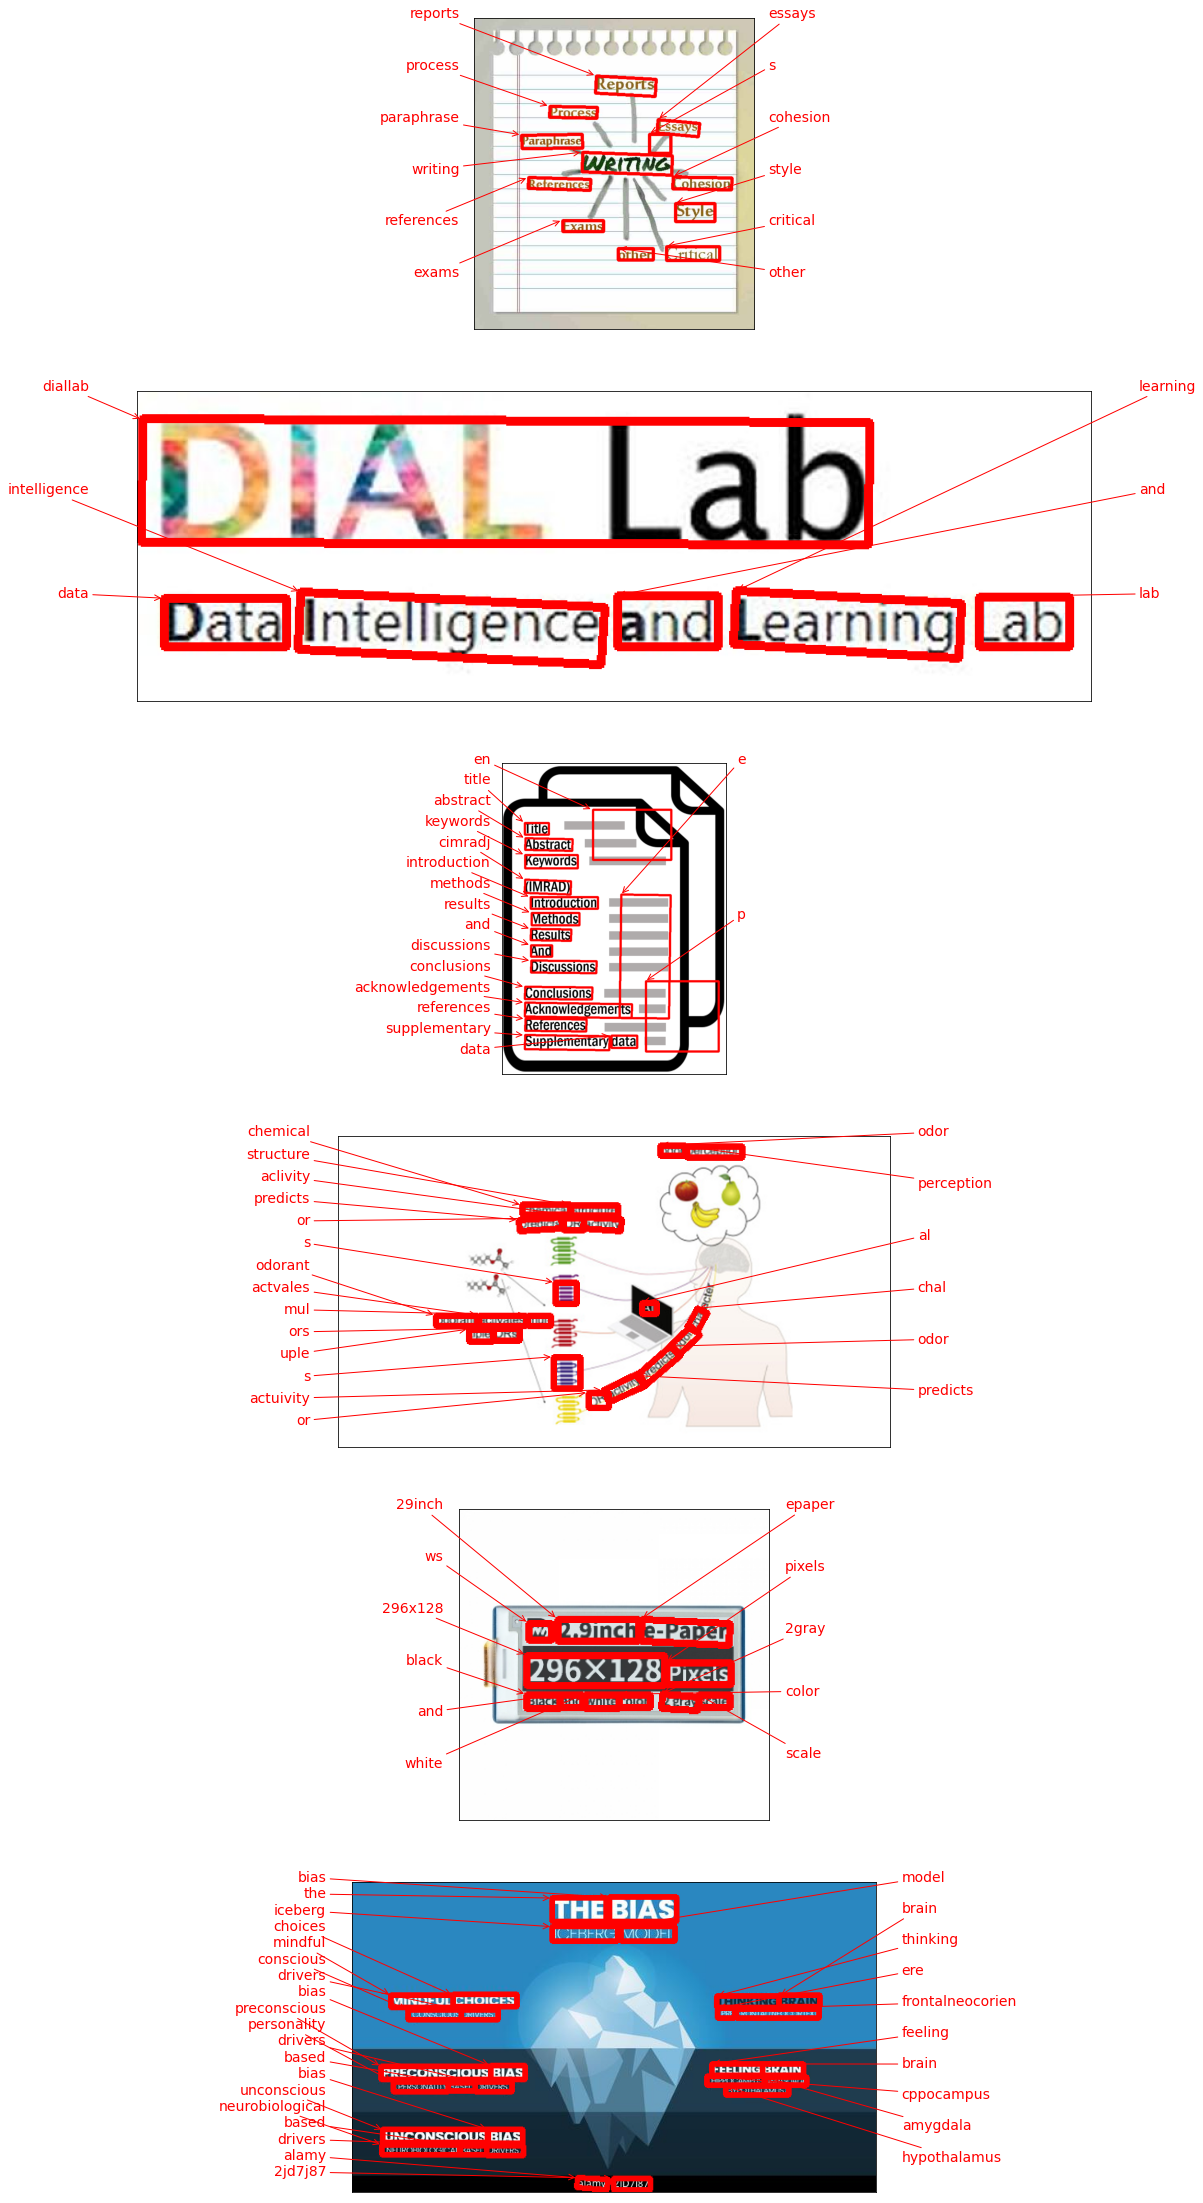

In [7]:
fig, ax = plt.subplots(nrows=6, figsize=(40,40))
for idx, ax in enumerate(ax):
  keras_ocr.tools.drawAnnotations(image=images[idx],
                                  predictions=prediction_groups[idx][0], ax=ax)

keras-ocr은 한글 데이터셋으로 훈련되어있지 않은 모델이라. 영어텍스트로만 이루어진 이미지들을 사용했습니다.
# Step2. Tesseract ocr
테서랙트는 구글에서 후원하는 ocr오픈소스 라이브러리로 현재는 버전4와 tesseract.js등으로 확장되는 등 많은 곳에서 사용되고있습니다. 버전4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함한 116개 국어를 지원하고 있습니다.
- ## 테서랙트로 문자 검출하고 이미지 자르기
테서랙트를 사용하면 한번에 이미지 내의 문자검출과 인식을 할 수 있습니다. 하지만 지금은 ocr이 이뤄지는 전체과정을 직접 거쳐보기위해 검출을 먼저 해봅시다.
  - **crop_word_regions()** : 선택한 이미지를 받아서, 문자검출을 진행한 후, 검출된 문자영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수입니다.
  - **pytesseract.image_to_data()** : 파이썬에서 편하게 사용하기 위해서 pytesseract의 Output을 사용해서 결괏값의 형식을 딕셔너리 형식으로 설정해주게 됩니다. 이렇게 인식된 결과는 바운딩 박서의 left, top, width, height 정보를 가지게 됩니다. 바운딩 박스를 사용해 이미지의 문자영역들을 파이썬 PIL 또는 opencv라이브러리를 사용해 잘라서 cropped_image_list에 담아 리턴하였습니다.

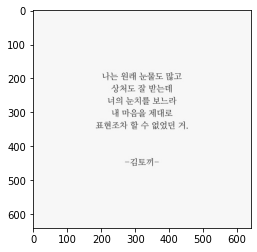

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png
/aiffel/aiffel/ocr_python/0011.png
/aiffel/aiffel/ocr_python/0012.png
/aiffel/aiffel/ocr_python/0013.png
/aiffel/aiffel/ocr_python/0014.png
/aiffel/aiffel/ocr_python/0015.png
/aiffel/aiffel/ocr_python/0016.png
/aiffel/aiffel/ocr_python/0017.png
/aiffel/aiffel/ocr_python/0018.png
/aiffel/aiffel/ocr_python/0019.png
/aiffel/aiffel/ocr_python/0020.png
/aiffel/aiffel/ocr_python/0021.png
/aiffel/aiffel/ocr_python/0022.png
/aiffel/aiffel/ocr_python/0023.png
/aiffel/aiffel/ocr_python/0024.png
/aiffel/aiffel/ocr_python/0025.png
/aiffel/aiffel/ocr_python/0026.png
/aiffel/aiffel/ocr_python/0027.png
/aiffel/aiffel/ocr_p

In [3]:
import os
import pytesseract
from PIL import Image
import cv2
from pytesseract import Output
import matplotlib.pyplot as plt


def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/sample.png'   
img_bgr = cv2.imread(img_file_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

- ## 테서랙트로 잘린 이미지에서 단어 인식하기
이제 문자 인식을 해 볼 차례입니다. 검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나오는 image_to_string()를 사용하게 됩니다. 이렇게 인식된 결과가 실제 이미지와 맞는지 확인해 봅시다.

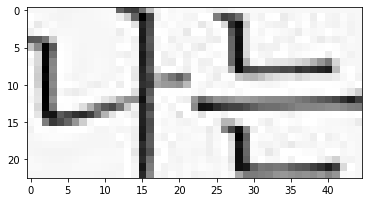

나는



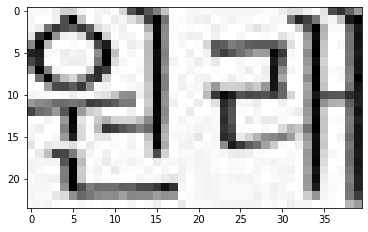

위 래



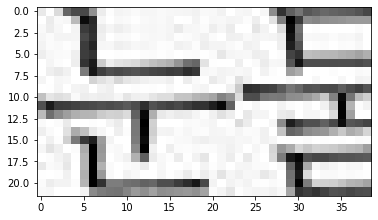

ㅠ근



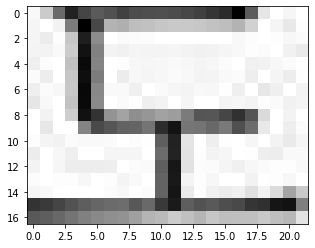

누.



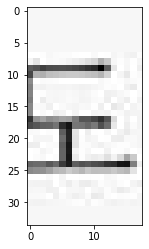

두



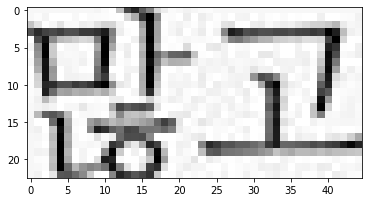

많고



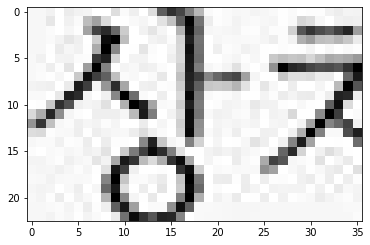

상



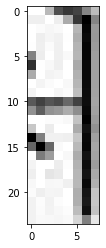

|



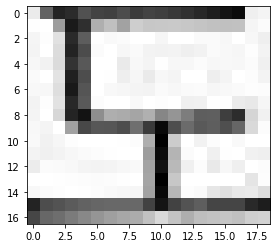

누



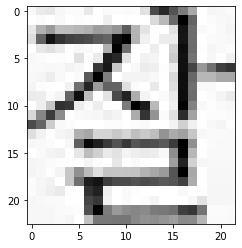

잠



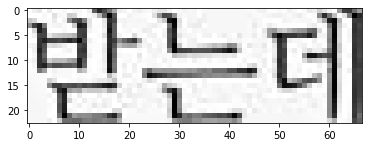

받는데



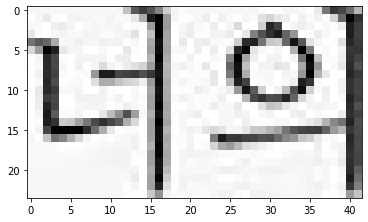

너의



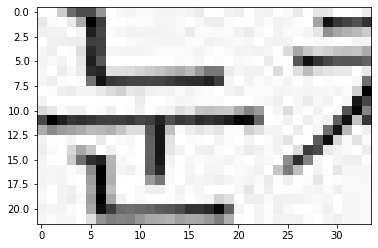

~



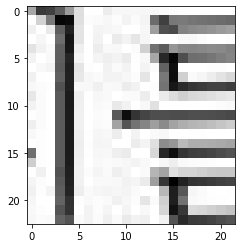

|틀



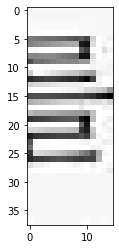

글



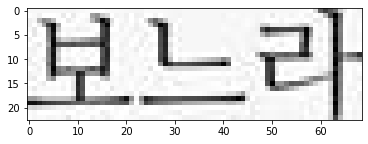

보느라



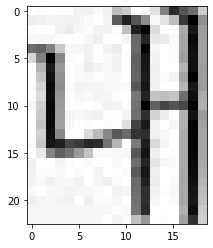

내



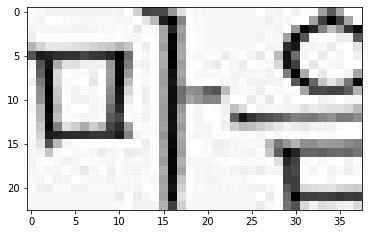

마음



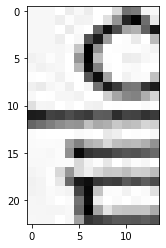

은



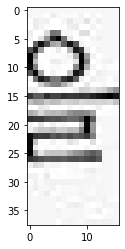

을



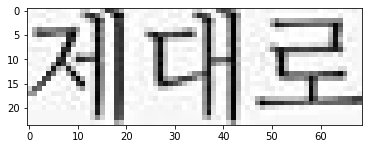

제대로



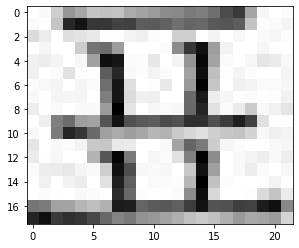

끔



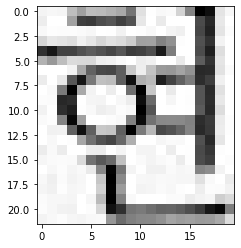

연



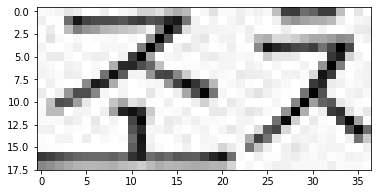

수ㅅ



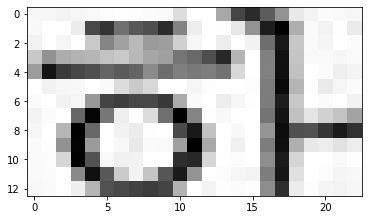

|



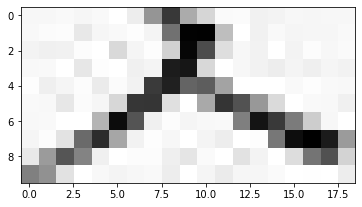

^



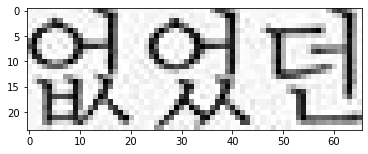

없었던



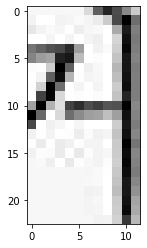

시



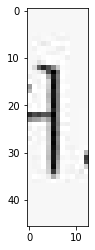

]



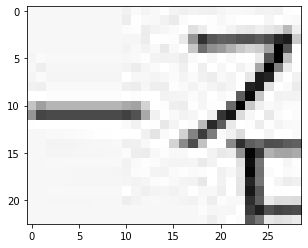

-구



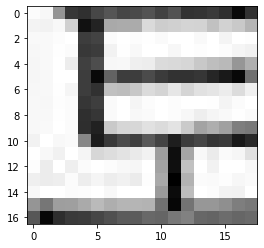

두



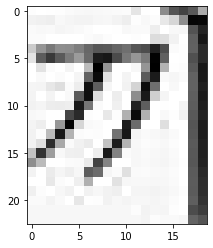

끼



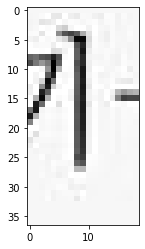

|



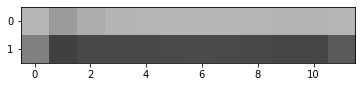

ㅠㅠ …：…

Done


In [4]:
def recognize_images_kor(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        
        import cv2
        img_bgr = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.show()
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images_kor(cropped_image_path_list)

# Step3. 테스트 결과정리
## keras-ocr
- 출력형태가 해당이미지에서 인식한 텍스트를 바운딩박스로 표시해주고, 바운딩박스에 연결된 화살표에 인식된 텍스트를 표시해줌
- 한눈에 보기가 쉬움
- 100퍼센트 다 인식되지않음, 텍스트가 아닌 부분에도 바운딩박스와 텍스트가 출력되는경우도 존재함
- 한글을 지원하지않음

## tesseract
- 이미지에서 인식된 텍스트 부분을 crop하고, crop된 이미지에 해당하는 텍스트가 출력됨
- 한글을 지원함
- 텍스트가 한 줄로 출력되기때문에, 해당 텍스트가 이미지의 어느부분을 인식해서 출력한것인지 알기 힘들다. 따라서 제대로 인식했는지 안했는지 확인하기가 힘들다
- 오차가 keras-ocr보다 심한것같다. 이미지의 화질이 낮았긴했지만, 제대로 인식한 텍스트가 많지는 않다

# Step4. 결과 분석과 결론 제시
우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다. 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다. 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.
### 구현하고자하는 서비스
: 눈이 안좋은 노인들이나 시력에 문제가 있는 사람들을 위해 카메라로 찍어주면, 해당 사진에 있는 텍스트를 읽어주는 서비스를 구현하고자합니다.

### 서비스를 구현하기위한 평가 기준
1. 한글을 지원해야함
2. 위에서 아래로, 왼쪽에서 오른쪽으로 읽어들여야함
3. 오차율이 적어야함

### 모델선정
: tesseract가 좀 더 나은 선택지입니다.

그이유는 첫번째로 keras-ocr는 한글을 지원하지않기때문에, 영어를 모르는 사람은 사용할 수 없습니다. 

두번째로 keras-ocr은 전체이미지에서 텍스트부분을 전체적으로 한번에 인식합니다. 반면에 tesseract는 위에서 아래로, 왼쪽에서 오른쪽으로 인식하면서 출력하기때문에, 사람이 읽는 순서와 동일하게 인식합니다.

하지만 tesseract는 위에서 보앗듯이 화질이 나쁘면 오차율이 많은것으로 보입니다. 하지만 요즘 카메라와 사진의 화질은 매우높기때문에 정확도가 좀 더 올라갈것으로 보입니다. 따라서 keras-ocr보단 tesseract가 서비스를 구현하기 더 적당해보입니다.

# 회고
- 이번 실습에선 여러가지 ocr모델을 사용해 이미지에 있는 텍스트를 인식해보았다. 서로 출력하는 방식이 달라서 원하는 서비스에 따라 선택지도 달라지는것같다.
- 정확도가 아직은 좀 부족해보인다.
- 실습 중 원래는 코랩을 이용했었다. keras-ocr을 진행할때는 아무문제 없이 진행했지만, tesseract를 진행할때 막혔었다.. 이유는 crop_word_regions()을 구현하는데 있어서 내부에 쓰여있는 코드들이 주피터노트북기준으로 쓰여져있었다. 특히 이미지들의 주소부분들이다. 그리고 디렉토리를 새로 만드는등 코랩에서 진행하기에는 나에게는 많은 어려움이있었다. 낯선 코드들이 많았고 이를 코랩에 맞게 전부 수정해줘야했다. 여러차례시도했지만 결국 반복되는 에러로 결국 주피터 노트북으로 다시 쓰고있다. 주피터 만만세...